# Main script to Join Data on Instrument 2 Fire Location

Modules: N/A <br>
Author: Jordan Meyer <br>
Email: jordan.meyer@berkeley.edu <br>
Date created: Feb 18, 2023 <br>

**Citations (data sources)**


**Citations (persons)**
1. Cornelia Ilin 

**Preferred environment**
1. Code written in Jupyter Notebooks

### Step 1: Import packages

In [2]:
import pandas as pd
import numpy as np
import netCDF4 as ncdf
import os
from datetime import date, timedelta
from math import pi
import fiona

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

# geography
import geopandas as gpd
import osmnx as ox
import shapely
from shapely.geometry import Point
import contextily as ctx 

#Moved from sklearn.neighbors to sklearn.metrics following their package change
import sklearn.metrics
dist = sklearn.metrics.DistanceMetric.get_metric(
    'haversine'
)

# ignore warnings
import warnings
warnings.filterwarnings(
    'ignore'
)


In [3]:
from tqdm.notebook import tqdm, trange

### Step 2: Define working directories

In [4]:
#Local directories on my machine (not gdrive)
in_dir = '../data/interim/'
out_dir = '../data/processed/'

In [5]:
ls

1.0-jam-wind-cleaning.ipynb
1.1-jam-wind-direction.ipynb
1.2-jam-wind-functions.ipynb
3.0-jmm-fires_cleaning.ipynb
3.1-jmm-fires_clean_eda.ipynb
3.2-jmm-fires_dropped_eda.ipynb
3.3-jam-fire_zcta_add.ipynb
3.4-jam-fires_final_stage_cleaning_zctas.ipynb
3.5-jam-fire-trim-multipolygons.ipynb
4.0-jam-join_data.ipynb
4.1-jam-join_data_instrument_1.ipynb
4.2-jam-join_data_instrument_2.ipynb
interactions.csv


### Step 3: Define functions

### Step 4: Read data

## Wind

Wind load from other file

In [6]:
wind_df = pd.read_csv(in_dir + "all_years_wind_data.csv",index_col=0).sort_values(["year_month","ZCTA10"]).reset_index(drop=True)

wind_df.head()

,Unnamed: 0,lat,lon,ZCTA10,u,v,wdir,wspd,year_month,year,month
0,0,37.465,-117.936,89010,0.504258,-0.719008,305.042938,0.878208,199101,1991,1
1,1,35.396,-116.322,89019,-0.172753,-0.946940,259.661102,0.962568,199101,1991,1
2,2,36.161,-116.139,89060,-0.435964,-0.812957,241.796738,0.922477,199101,1991,1
3,3,35.957,-115.897,89061,-0.560538,-1.176384,244.522552,1.303105,199101,1991,1
4,4,39.520,-120.032,89439,0.042253,0.205661,78.390099,0.209957,199101,1991,1


## Fire

Finsh cleaning some fire things and then join fire to wind 

In [7]:
fire_df = pd.read_csv(in_dir + "fire_zipcodes_compressed.csv",index_col=0)

#Extract year and month, filter for fires in scope 1991+
fire_df['year'] = fire_df['ALARM_DATE'].str[:4]
fire_df = fire_df[fire_df['year'].astype(int)>1990]

#Extract Month and End Year/Month
fire_df['month'] = fire_df['ALARM_DATE'].str[5:7]
fire_df['year_month'] = fire_df['year']+fire_df['month']
fire_df['month'] = fire_df['month'].astype(int)
fire_df['end_year'] = fire_df['CONT_DATE'].str[:4]
fire_df['end_month'] = fire_df['CONT_DATE'].str[5:7].astype(int)

#Give each fire a unique index code for later 
fire_df = fire_df.drop_duplicates().reset_index().rename(columns={'Index':'fire_index'})

#Calculate duration with monthly basis, add 1 as proxy for ceiling calculation ie fire at any time in month counts regardless of start date
fire_df['duration_months'] = (fire_df['end_month']-fire_df['month'])+1
# fire_df = fire_df.set_index(['ZCTA','ALARM_DATE'])

# For fires that span multiple years replace the values of the duration on a yearly basis and duplciate the entry for the next year
for idx,fire in fire_df[fire_df['end_year'] != fire_df['year']].iterrows():
    fire['FIRE_NAME'] = fire['FIRE_NAME']+" CONT"
    fire['year'] = int(fire['year'])+1
    fire['month'] = "01"
    fire['year_month'] = str(fire['year']) + fire['month']
    #Hard coding duration = 1 as all fires that spanned across years happened to be put out in January
    fire['duration_months'] = 1
    
    #Replace the total durations with the duration in year, clear up negatives durations from month 2 < month 1
    fire_df.loc[idx,'duration_months'] =  (13-fire_df.loc[idx,'month'])
    
    #Append the new year's entry for the fire's continuation
    fire_df = fire_df.append(fire)


In [8]:
fire_df

,fire_index,FIRE_NAME,ALARM_DATE,CONT_DATE,CAUSE,GIS_ACRES,Shape_Length,Shape_Area,index_right,ZCTA,fire_centroid,DURATION,FIRE_AREA_KM2,year,month,year_month,end_year,end_month,duration_months
0,0,NELSON,2020-06-18,2020-06-23,11.0,109.602280,3252.523280,4.435447e+05,405.0,95648.0,POINT (-121.3480590211847 38.88804091206984),5 days,0.443546,2020,6,202006,2020,6,1
1,1,AMORUSO,2020-06-01,2020-06-04,2.0,685.585022,9653.760308,2.774464e+06,1217.0,95747.0,POINT (-121.3708983104108 38.82756661261951),3 days,2.774464,2020,6,202006,2020,6,1
2,3,FLEMING,2020-03-31,2020-04-01,9.0,12.931545,1577.155857,5.233211e+04,405.0,95648.0,POINT (-121.2734135751918 38.9623284462546),1 days,0.052332,2020,3,202003,2020,4,2
3,4,MELANESE,2020-04-14,2020-04-19,18.0,10.315964,1035.787625,4.174722e+04,933.0,95966.0,POINT (-121.3006534927401 39.48636412414794),5 days,0.041747,2020,4,202004,2020,4,1
4,5,PFE,2020-07-05,2020-07-05,14.0,36.701931,2348.114043,1.485274e+05,1217.0,95747.0,POINT (-121.3810176618852 38.73133921489409),0 days,0.148527,2020,7,202007,2020,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353,237,CASTLE CONT,2020-08-19,2021-01-04,1.0,170647.921875,723127.356361,6.905877e+08,39.0,93527.0,POINT (-118.5459427622953 36.21685569944568),138 days,690.587671,2021,01,202101,2021,1,1
354,237,CASTLE CONT,2020-08-19,2021-01-04,1.0,170647.921875,723127.356361,6.905877e+08,913.0,93271.0,POINT (-118.5459427622953 36.21685569944568),138 days,690.587671,2021,01,202101,2021,1,1
355,237,CASTLE CONT,2020-08-19,2021-01-04,1.0,170647.921875,723127.356361,6.905877e+08,1308.0,93208.0,POINT (-118.5459427622953 36.21685569944568),138 days,690.587671,2021,01,202101,2021,1,1
356,237,CASTLE CONT,2020-08-19,2021-01-04,1.0,170647.921875,723127.356361,6.905877e+08,544.0,93265.0,POINT (-118.5459427622953 36.21685569944568),138 days,690.587671,2021,01,202101,2021,1,1


In [9]:
# For all fires that are longer than 1 month insert another entry with remaing duration into the dataframe
print(fire_df[fire_df['duration_months']>1].shape)
for idx,fire in fire_df[fire_df['duration_months']>1].iterrows():
    month = 2
    duration = fire['duration_months'] 
    while duration > 1:
        # print(idx, fire_df.iloc[idx]['duration_months'], duration-1)
        #fire['FIRE_NAME'] = fire_df.iloc[idx]['FIRE_NAME'] + f"_{month}"
        fire['duration_months'] -= 1
        fire['month'] += 1
        fire['year_month'] = (str(fire['year']) + str(fire['month'])) if len(str(fire['month']))>1 else (str(fire['year']) + "0" + str(fire['month'])) 
        fire_df = fire_df.append(fire)
        duration = fire['duration_months']
        month += 1


(1419, 19)


In [10]:
pd_fire = pd.DataFrame(fire_df)#.drop('fire_centroid',axis=1))

In [11]:
pd_fire

,fire_index,FIRE_NAME,ALARM_DATE,CONT_DATE,CAUSE,GIS_ACRES,Shape_Length,Shape_Area,index_right,ZCTA,fire_centroid,DURATION,FIRE_AREA_KM2,year,month,year_month,end_year,end_month,duration_months
0,0,NELSON,2020-06-18,2020-06-23,11.0,109.602280,3252.523280,4.435447e+05,405.0,95648.0,POINT (-121.3480590211847 38.88804091206984),5 days,0.443546,2020,6,202006,2020,6,1
1,1,AMORUSO,2020-06-01,2020-06-04,2.0,685.585022,9653.760308,2.774464e+06,1217.0,95747.0,POINT (-121.3708983104108 38.82756661261951),3 days,2.774464,2020,6,202006,2020,6,1
2,3,FLEMING,2020-03-31,2020-04-01,9.0,12.931545,1577.155857,5.233211e+04,405.0,95648.0,POINT (-121.2734135751918 38.9623284462546),1 days,0.052332,2020,3,202003,2020,4,2
3,4,MELANESE,2020-04-14,2020-04-19,18.0,10.315964,1035.787625,4.174722e+04,933.0,95966.0,POINT (-121.3006534927401 39.48636412414794),5 days,0.041747,2020,4,202004,2020,4,1
4,5,PFE,2020-07-05,2020-07-05,14.0,36.701931,2348.114043,1.485274e+05,1217.0,95747.0,POINT (-121.3810176618852 38.73133921489409),0 days,0.148527,2020,7,202007,2020,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6819,19698,TULLEY,2016-08-22,2016-09-04,7.0,607.445740,13095.080608,2.458246e+06,277.0,95546.0,POINT (-123.8140318155857 41.28541623395056),13 days,2.458246,2016,9,201609,2016,9,1
6844,19720,DOCKERY,2016-07-30,2016-08-17,10.0,27.963249,2655.210701,1.131633e+05,51.0,96130.0,POINT (-120.6873444598079 40.42539576204376),18 days,0.113163,2016,8,201608,2016,8,1
6845,19721,HOWARD,2016-09-11,2016-10-17,6.0,379.622528,7898.270122,1.536278e+06,1021.0,96015.0,POINT (-120.9157313359543 41.47071744410114),36 days,1.536278,2016,10,201610,2016,10,1
6846,19722,WILLARD,2016-09-11,2016-11-28,14.0,2573.955322,27364.478495,1.041643e+07,51.0,96130.0,POINT (-120.7510806570093 40.37593783404107),78 days,10.416427,2016,10,201610,2016,11,2


In [12]:
pd_fire['ZCTA'] = pd_fire['ZCTA'].astype(str).str[:5]
pd_fire['year_month'] = pd_fire['year_month'].str[:]


In [13]:
pd_fire.dtypes

fire_index           int64
FIRE_NAME           object
ALARM_DATE          object
CONT_DATE           object
CAUSE              float64
GIS_ACRES          float64
Shape_Length       float64
Shape_Area         float64
index_right        float64
ZCTA                object
fire_centroid       object
DURATION            object
FIRE_AREA_KM2      float64
year                object
month               object
year_month          object
end_year            object
end_month            int64
duration_months      int64
dtype: object

In [14]:
fire_ready = pd_fire[~pd_fire['ZCTA'].isna()]\
    .reset_index(drop=True)\
    .drop_duplicates()


In [15]:
fire_ready.head()

,fire_index,FIRE_NAME,ALARM_DATE,CONT_DATE,CAUSE,GIS_ACRES,Shape_Length,Shape_Area,index_right,ZCTA,fire_centroid,DURATION,FIRE_AREA_KM2,year,month,year_month,end_year,end_month,duration_months
0,0,NELSON,2020-06-18,2020-06-23,11.0,109.602280,3252.523280,4.435447e+05,405.0,95648,POINT (-121.3480590211847 38.88804091206984),5 days,0.443546,2020,6,202006,2020,6,1
1,1,AMORUSO,2020-06-01,2020-06-04,2.0,685.585022,9653.760308,2.774464e+06,1217.0,95747,POINT (-121.3708983104108 38.82756661261951),3 days,2.774464,2020,6,202006,2020,6,1
2,3,FLEMING,2020-03-31,2020-04-01,9.0,12.931545,1577.155857,5.233211e+04,405.0,95648,POINT (-121.2734135751918 38.9623284462546),1 days,0.052332,2020,3,202003,2020,4,2
3,4,MELANESE,2020-04-14,2020-04-19,18.0,10.315964,1035.787625,4.174722e+04,933.0,95966,POINT (-121.3006534927401 39.48636412414794),5 days,0.041747,2020,4,202004,2020,4,1
4,5,PFE,2020-07-05,2020-07-05,14.0,36.701931,2348.114043,1.485274e+05,1217.0,95747,POINT (-121.3810176618852 38.73133921489409),0 days,0.148527,2020,7,202007,2020,7,1


In [16]:
wind_ready = wind_df\
    .drop('Unnamed: 0', axis=1)\
    .rename(columns={'ZCTA10':'ZCTA'})\
    .reset_index(drop=True)\
    .drop_duplicates()

In [17]:
wind_ready['year_month'] = wind_ready['year_month'].astype(str)
wind_ready['ZCTA'] = wind_ready['ZCTA'].astype(str)

In [18]:
wind_ready.dtypes[['year_month','ZCTA']]

year_month    object
ZCTA          object
dtype: object

In [19]:
fire_ready.dtypes[['year_month','ZCTA']]

year_month    object
ZCTA          object
dtype: object

In [20]:
wind_fire = wind_ready.merge(fire_ready, on=['year_month','ZCTA'], how='left')

In [21]:
wind_fire

,lat,lon,ZCTA,u,v,wdir,wspd,year_month,year_x,month_x,...,Shape_Area,index_right,fire_centroid,DURATION,FIRE_AREA_KM2,year_y,month_y,end_year,end_month,duration_months
0,37.465,-117.936,89010,0.504258,-0.719008,305.042938,0.878208,199101,1991,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,35.396,-116.322,89019,-0.172753,-0.946940,259.661102,0.962568,199101,1991,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,36.161,-116.139,89060,-0.435964,-0.812957,241.796738,0.922477,199101,1991,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,35.957,-115.897,89061,-0.560538,-1.176384,244.522552,1.303105,199101,1991,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,39.520,-120.032,89439,0.042253,0.205661,78.390099,0.209957,199101,1991,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628502,39.149,-120.248,96146,0.636599,0.953782,56.279018,1.146716,202212,2022,12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
628503,39.236,-120.062,96148,0.636599,0.953782,56.279018,1.146716,202212,2022,12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
628504,38.732,-120.033,96150,0.071517,0.472164,81.387100,0.477549,202212,2022,12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
628505,39.184,-120.427,96161,-0.217010,0.239125,132.224274,0.322915,202212,2022,12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## PM2.5

Load PM2.5 from lawis files downloaded from gdrive

In [22]:
aqi1 = pd.read_csv(in_dir + 'finalpm25.csv', index_col = 0)
aqi1

,year_month,ZIP10,pm25
204,2017-01,89010,1.842857
205,2017-02,89010,3.528571
206,2017-03,89010,3.242857
207,2017-04,89010,3.700000
208,2017-05,89010,5.242857
...,...,...,...
585307,2016-12,96148,1.713333
585308,2016-12,96150,1.719288
585309,2016-12,96155,0.771287
585310,2016-12,96161,1.416996


In [23]:
pm25_df = aqi1.reset_index(drop=True)\
    .rename(columns={'ZIP10':'ZCTA',
                    'year_month':'old_ym'})

In [24]:
pm25_df.shape

(626400, 3)

In [25]:
pm25_df['year_month']=pm25_df['old_ym'].str[:4]+pm25_df['old_ym'].str[5:]
pm25_df['ZCTA'] = pm25_df['ZCTA'].astype(str)
pm25_ready = pm25_df.drop('old_ym',axis=1)

In [26]:
pm25_ready.dtypes

ZCTA           object
pm25          float64
year_month     object
dtype: object

In [27]:
wfp_df = wind_fire.merge(pm25_ready, on=['year_month','ZCTA'], how='left')

In [28]:
wfp_df.head()

,lat,lon,ZCTA,u,v,wdir,wspd,year_month,year_x,month_x,...,index_right,fire_centroid,DURATION,FIRE_AREA_KM2,year_y,month_y,end_year,end_month,duration_months,pm25
0,37.465,-117.936,89010,0.504258,-0.719008,305.042938,0.878208,199101,1991,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.450976
1,35.396,-116.322,89019,-0.172753,-0.946940,259.661102,0.962568,199101,1991,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.846541
2,36.161,-116.139,89060,-0.435964,-0.812957,241.796738,0.922477,199101,1991,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.385000
3,35.957,-115.897,89061,-0.560538,-1.176384,244.522552,1.303105,199101,1991,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.150000
4,39.520,-120.032,89439,0.042253,0.205661,78.390099,0.209957,199101,1991,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.389565


In [29]:
wfp_df['treatment'] = ~wfp_df['duration_months'].isna()

In [30]:
print(f"Number of months/zips in treatment group {np.sum(wfp_df['treatment'])}")

Number of months/zips in treatment group 7584


In [31]:
print(f"Number of months/zips in control group {np.sum(~wfp_df['treatment'])}")

Number of months/zips in control group 620923


In [32]:
wfp_df.dtypes

lat                float64
lon                float64
ZCTA                object
u                  float64
v                  float64
wdir               float64
wspd               float64
year_month          object
year_x               int64
month_x              int64
fire_index         float64
FIRE_NAME           object
ALARM_DATE          object
CONT_DATE           object
CAUSE              float64
GIS_ACRES          float64
Shape_Length       float64
Shape_Area         float64
index_right        float64
fire_centroid       object
DURATION            object
FIRE_AREA_KM2      float64
year_y              object
month_y             object
end_year            object
end_month          float64
duration_months    float64
pm25               float64
treatment             bool
dtype: object

In [33]:
final_df = wfp_df.drop(['year_x','month_x', 'ALARM_DATE', 'FIRE_NAME', 
                        'CONT_DATE', 'CAUSE','Shape_Length', 'Shape_Area', 
                        'index_right','year_y', 'month_y','duration_months',
                        'end_year', 'end_month'],axis=1)

In [97]:
final_df

,lat,lon,ZCTA,u,v,wdir,wspd,year_month,GIS_ACRES,DURATION,FIRE_AREA_KM2,pm25,treatment
0,37.465,-117.936,89010,0.504258,-0.719008,305.042938,0.878208,199101,NaN,NaN,NaN,12.450976,False
1,35.396,-116.322,89019,-0.172753,-0.946940,259.661102,0.962568,199101,NaN,NaN,NaN,10.846541,False
2,36.161,-116.139,89060,-0.435964,-0.812957,241.796738,0.922477,199101,NaN,NaN,NaN,12.385000,False
3,35.957,-115.897,89061,-0.560538,-1.176384,244.522552,1.303105,199101,NaN,NaN,NaN,10.150000,False
4,39.520,-120.032,89439,0.042253,0.205661,78.390099,0.209957,199101,NaN,NaN,NaN,8.389565,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
628502,39.149,-120.248,96146,0.636599,0.953782,56.279018,1.146716,202212,NaN,NaN,NaN,NaN,False
628503,39.236,-120.062,96148,0.636599,0.953782,56.279018,1.146716,202212,NaN,NaN,NaN,NaN,False
628504,38.732,-120.033,96150,0.071517,0.472164,81.387100,0.477549,202212,NaN,NaN,NaN,NaN,False
628505,39.184,-120.427,96161,-0.217010,0.239125,132.224274,0.322915,202212,NaN,NaN,NaN,NaN,False


In [98]:
final_df.to_csv(out_dir + 'instrument2.csv')

In [34]:
wind_ready

,lat,lon,ZCTA,u,v,wdir,wspd,year_month,year,month
0,37.465,-117.936,89010,0.504258,-0.719008,305.042938,0.878208,199101,1991,1
1,35.396,-116.322,89019,-0.172753,-0.946940,259.661102,0.962568,199101,1991,1
2,36.161,-116.139,89060,-0.435964,-0.812957,241.796738,0.922477,199101,1991,1
3,35.957,-115.897,89061,-0.560538,-1.176384,244.522552,1.303105,199101,1991,1
4,39.520,-120.032,89439,0.042253,0.205661,78.390099,0.209957,199101,1991,1
...,...,...,...,...,...,...,...,...,...,...
627067,39.149,-120.248,96146,0.636599,0.953782,56.279018,1.146716,202212,2022,12
627068,39.236,-120.062,96148,0.636599,0.953782,56.279018,1.146716,202212,2022,12
627069,38.732,-120.033,96150,0.071517,0.472164,81.387100,0.477549,202212,2022,12
627070,39.184,-120.427,96161,-0.217010,0.239125,132.224274,0.322915,202212,2022,12


In [759]:
fire_df

,fire_index,FIRE_NAME,ALARM_DATE,CONT_DATE,CAUSE,GIS_ACRES,Shape_Length,Shape_Area,index_right,ZCTA,fire_centroid,DURATION,FIRE_AREA_KM2,year,month,year_month,end_year,end_month,duration_months
0,0,NELSON,2020-06-18,2020-06-23,11.0,109.602280,3252.523280,4.435447e+05,405.0,95648,POINT (-121.3480590211847 38.88804091206984),5 days,0.443546,2020,6,202006,2020,6,1
1,1,AMORUSO,2020-06-01,2020-06-04,2.0,685.585022,9653.760308,2.774464e+06,1217.0,95747,POINT (-121.3708983104108 38.82756661261951),3 days,2.774464,2020,6,202006,2020,6,1
2,3,FLEMING,2020-03-31,2020-04-01,9.0,12.931545,1577.155857,5.233211e+04,405.0,95648,POINT (-121.2734135751918 38.9623284462546),1 days,0.052332,2020,3,202003,2020,4,2
3,4,MELANESE,2020-04-14,2020-04-19,18.0,10.315964,1035.787625,4.174722e+04,933.0,95966,POINT (-121.3006534927401 39.48636412414794),5 days,0.041747,2020,4,202004,2020,4,1
4,5,PFE,2020-07-05,2020-07-05,14.0,36.701931,2348.114043,1.485274e+05,1217.0,95747,POINT (-121.3810176618852 38.73133921489409),0 days,0.148527,2020,7,202007,2020,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6819,19698,TULLEY,2016-08-22,2016-09-04,7.0,607.445740,13095.080608,2.458246e+06,277.0,95546,POINT (-123.8140318155857 41.28541623395056),13 days,2.458246,2016,9,201609,2016,9,1
6844,19720,DOCKERY,2016-07-30,2016-08-17,10.0,27.963249,2655.210701,1.131633e+05,51.0,96130,POINT (-120.6873444598079 40.42539576204376),18 days,0.113163,2016,8,201608,2016,8,1
6845,19721,HOWARD,2016-09-11,2016-10-17,6.0,379.622528,7898.270122,1.536278e+06,1021.0,96015,POINT (-120.9157313359543 41.47071744410114),36 days,1.536278,2016,10,201610,2016,10,1
6846,19722,WILLARD,2016-09-11,2016-11-28,14.0,2573.955322,27364.478495,1.041643e+07,51.0,96130,POINT (-120.7510806570093 40.37593783404107),78 days,10.416427,2016,10,201610,2016,11,2


In [36]:
fire_ready['geometry'] = gpd.GeoSeries.from_wkt(fire_ready['fire_centroid'])
fire_ready['lon'] = fire_ready['geometry'].apply(lambda p: p.x)
fire_ready['lat'] = fire_ready['geometry'].apply(lambda p: p.y)
fire_ready['sq_mi'] = fire_ready['GIS_ACRES']/640
fire_ready['radius_mi'] = np.sqrt(fire_ready['sq_mi']/np.pi)

It looks like most fires have a radius of under 5 miles. Using a dynamic distance may be useless so I'm going to start with 20 miles, we can validate with pm2.5 to see where we see the effects in the next iteration

<Axes: >

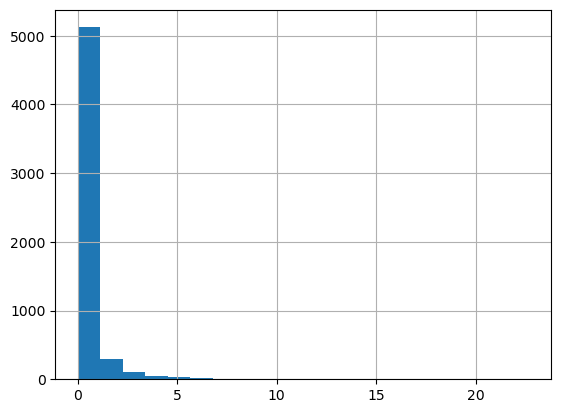

In [37]:
fire_ready['radius_mi'].drop_duplicates().hist(bins=20)

Fires only 'touch' 833 different zip codes 

In [38]:
len(fire_ready['ZCTA'].unique())

833

There are a total of 1633 zip codes in the state so approx 50% have had a fire inside them at some point

In [39]:
len(wind_ready['ZCTA'].unique())

1633

In [122]:
def fire_boundary(wind, fire):
    '''
    params:
    -------
    wind: wind cleaned data
    fire: fire semi-cleaned data
    
    return:
    -------
    df3: dataframe with distances from each fire during time period
    '''
    
    # create labels
    wind['wind_lat_lon'] = [str(xy) for xy in zip(wind.lat, wind.lon)]
    fire['fire_lat_lon'] = [str(xy) for xy in zip(fire.lat, fire.lon)]

    ## for each point in wind data find the nearest point in the census data ##
    ###############
    # keep only unique points in fire data
    df1_unique = wind.drop_duplicates(
        ['wind_lat_lon']
    
    )
    df2_unique = fire.drop_duplicates(
        ['fire_lat_lon']
    )
    
    df1_unique.reset_index(
        drop=True,
        inplace=True
    )
    
    df2_unique.reset_index(
        drop=True,
        inplace=True
    )

    # transform to radians
    df1_unique['lat_r'] = np.radians(df1_unique.lat)
    df1_unique['lon_r'] = np.radians(df1_unique.lon)
    df2_unique['lat_r'] = np.radians(df2_unique.lat)
    df2_unique['lon_r'] = np.radians(df2_unique.lon)

    # compute pairwise distance (in miles)
    dist_matrix = (dist.pairwise(
        df2_unique[['lat_r', 'lon_r']],
        df1_unique[['lat_r', 'lon_r']],
    ))*3959
        
    # create a df from dist_matrix
    dist_matrix = pd.DataFrame(
        dist_matrix,
        index=df2_unique['fire_index'],
        columns=df1_unique['ZCTA']
    ) 
    return dist_matrix.T

In [572]:
dist_df = fire_boundary(wind_ready,fire_ready)
dist_df

fire_index,0,1,3,4,5,6,7,8,9,10,...,19721,19722,19723,19724,19725,19726,19727,19728,19729,19730
ZCTA,,,,,,,,,,,,,,,,,,,,,
89010,209.784488,209.035336,208.627307,229.394707,206.737358,218.838665,216.038569,226.588340,226.303575,208.957379,...,319.123999,251.680688,264.825828,338.002187,111.184487,148.337551,128.039928,132.475798,115.294666,139.923583
89019,367.121833,365.432157,367.354761,392.914821,361.723879,378.837568,376.467808,389.356902,388.796593,363.863147,...,487.679355,420.275310,400.885469,191.324011,101.117394,67.382649,123.677381,113.000379,67.487325,124.146145
89060,341.951585,340.818891,341.312496,363.431339,337.903974,351.999965,349.323211,360.493392,360.152663,340.104959,...,447.872863,383.835959,386.676246,245.140578,107.777834,95.623900,136.240025,128.641709,72.558188,141.293224
89061,361.133956,359.955902,360.559467,382.880297,356.971181,371.306402,368.647617,379.914802,379.563656,359.168395,...,467.100306,403.305903,404.649097,233.975195,119.597674,100.271388,146.999697,138.346534,83.368515,150.762093
89439,82.898204,86.213298,76.800081,67.677560,90.544632,76.410696,73.061286,69.067264,70.107323,91.681319,...,142.562148,70.347517,173.474108,506.709376,275.687789,319.769862,279.159159,288.438167,291.637846,290.063782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97635,222.065696,226.419205,216.100936,181.596492,232.993324,206.263021,205.004177,187.615588,189.450894,232.692648,...,49.524223,114.638845,296.953250,671.848872,440.474585,482.514582,447.225512,455.729426,451.236155,458.522867
97635,221.998019,226.351376,216.036233,181.518019,232.926717,206.188974,204.934024,187.538329,189.373250,232.623699,...,49.348017,114.580981,296.837848,671.925586,440.547513,482.597056,447.282489,455.791037,451.328055,458.577682
97635,221.876932,226.230003,215.920524,181.377633,232.807525,206.056463,204.808534,187.400105,189.234325,232.500289,...,49.032666,114.478240,296.630606,672.063929,440.679166,482.745853,447.385437,455.902316,451.493831,458.676731


In [124]:
def fire_bearings(wind, fire):
    '''
    params:
    -------
    wind: wind cleaned data
    fire: fire semi-cleaned data
    
    return:
    -------
    df3: dataframe with distances from each fire during time period
    '''
    
    # create labels
    wind['wind_lat_lon'] = [str(xy) for xy in zip(wind.lat, wind.lon)]
    fire['fire_lat_lon'] = [str(xy) for xy in zip(fire.lat, fire.lon)]

    ###############
    # keep only unique points in fire data
    df1_unique = wind.drop_duplicates(
        ['wind_lat_lon']
    
    )
    df2_unique = fire.drop_duplicates(
        ['fire_lat_lon']
    )
    
    df1_unique.reset_index(
        drop=True,
        inplace=True
    )
    
    df2_unique.reset_index(
        drop=True,
        inplace=True
    )
    
    # compute pairwise distance (in miles)
    bearing_matrix=np.zeros((df1_unique.shape[0],df2_unique.shape[0]))
    for idx in range(df1_unique.shape[0]):
        pa_lat = df1_unique['lat'][idx]
        pa_lon = df1_unique['lon'][idx]
        wdir_ba = df1_unique['wdir'][idx]
        for idy in range(df2_unique.shape[0]):
            pb_lat = df2_unique['lat'][idy]
            pb_lon = df2_unique['lon'][idy]
            
            if pb_lon > pa_lon:
                d_X = -np.cos(pa_lat) * np.sin(pa_lon - pb_lon)
            else:
                d_X = np.cos(pa_lat) * np.sin(pa_lon - pb_lon)

            if pb_lat >pa_lat:
                d_Y = -np.cos(pb_lat) * np.sin(pa_lat) - np.sin(pb_lat) * np.cos(pa_lat) * np.cos(pa_lon - pb_lon)
            else:
                d_Y = np.cos(pb_lat) * np.sin(pa_lat) - np.sin(pb_lat) * np.cos(pa_lat) * np.cos(pa_lon - pb_lon)

            B_ba = np.arctan2(d_X,d_Y)*(180/np.pi)%360
            
            angle_diff = np.max([B_ba,wdir_ba]) - np.min([B_ba,wdir_ba])
            
            if angle_diff >180:
                upwind_effect = (angle_diff)/360
            else:
                upwind_effect = 1-(angle_diff)/360
                
            bearing_matrix[idx,idy] = upwind_effect
            

    

    # create a df from dist_matrix
    bearing_matrix = pd.DataFrame(
        bearing_matrix,
        index=df1_unique['ZCTA'],
        columns=df2_unique['fire_index']
    )  
    
    return bearing_matrix

In [125]:
wind_locs = wind_ready[['ZCTA','lon','lat','wdir','wspd']].drop_duplicates()
# wind_locs

In [647]:
fire_locs = fire_ready[['fire_index','lon','lat','radius_mi']].drop_duplicates()
# fire_locs

In [127]:
bearings = fire_bearings(wind_locs,fire_locs)
bearings.to_csv('bearings.csv')

In [99]:
# bearings = pd.read_csv('interactions.csv',index_col=0)

In [131]:
bearings

fire_index,0,1,3,4,5,6,7,8,9,10,...,19721,19722,19723,19724,19725,19726,19727,19728,19729,19730
ZCTA,,,,,,,,,,,,,,,,,,,,,
89010,0.889575,0.893569,0.877717,0.885649,0.896248,0.892742,0.882706,0.886995,0.889156,0.902112,...,0.619994,0.690069,0.932567,0.516846,0.832709,0.773576,0.759675,0.785607,0.761760,0.751960
89019,0.572339,0.580642,0.554791,0.525731,0.589362,0.546271,0.535974,0.506763,0.500158,0.592444,...,0.639431,0.665894,0.733366,0.848007,0.997566,0.889570,0.968686,0.988393,0.913633,0.993551
89060,0.684403,0.682568,0.687970,0.848731,0.680653,0.707593,0.709682,0.860313,0.866081,0.680654,...,0.834776,0.834141,0.669989,0.818841,0.652564,0.664471,0.662997,0.663323,0.654034,0.665415
89061,0.637840,0.642698,0.627505,0.678458,0.647635,0.607169,0.600085,0.591666,0.559808,0.648518,...,0.789865,0.790277,0.693607,0.908853,0.741259,0.717145,0.703654,0.707385,0.774174,0.698158
89439,0.699592,0.706343,0.692368,0.550954,0.715738,0.639374,0.644971,0.504444,0.508473,0.713270,...,0.739221,0.755190,0.760240,0.814885,0.565905,0.676121,0.636038,0.642813,0.531704,0.654185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97635,0.605404,0.584955,0.641255,0.808771,0.560470,0.696171,0.708958,0.789826,0.782196,0.561482,...,0.856495,0.893216,0.534237,0.603652,0.830652,0.896753,0.813046,0.835226,0.897207,0.829555
97635,0.919070,0.898509,0.955098,0.877442,0.873884,0.989787,0.976977,0.896297,0.903900,0.874922,...,0.829981,0.793275,0.779243,0.709087,0.855615,0.789698,0.873369,0.851231,0.789069,0.856968
97635,0.664107,0.643341,0.700456,0.867809,0.618463,0.755929,0.768779,0.849117,0.841563,0.619548,...,0.914807,0.951479,0.523940,0.547547,0.889540,0.955128,0.871522,0.893584,0.956069,0.887729


In [133]:
np.sum(np.sum(dist_df.T<=25))

135382

In [137]:
close_bearings = bearings[dist_df<=25]
close_bearings

fire_index,0,1,3,4,5,6,7,8,9,10,...,19721,19722,19723,19724,19725,19726,19727,19728,19729,19730
ZCTA,,,,,,,,,,,,,,,,,,,,,
89010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89060,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89061,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89439,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97635,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97635,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97635,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [476]:
treatment = close_bearings >=.75 

In [477]:
treatment.T

ZCTA,89010,89019,89060,89061,89439,90001,90002,90003,90004,90005,...,97635,97635,97635,97635,97635,97635,97635,97635,97635,97635
fire_index,,,,,,,,,,,,,,,,,,,,,
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19726,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
19727,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
19728,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [603]:
np.sum(treatment,axis=1)

ZCTA
89010     0
89019     0
89060     0
89061     1
89439    33
         ..
97635    22
97635    25
97635    26
97635    24
97635     3
Length: 1644, dtype: int64

In [648]:
fire_indexed = fire_ready[['fire_index','year_month','ZCTA','radius_mi']]

In [659]:
idk = fire_indexed.merge(treatment.T, left_on='fire_index',right_on='fire_index',how='left')
idk['treatment'] = idk.loc['89010':].any(axis=1)
fire_treatment = idk[['fire_index','year_month','ZCTA','treatment','radius_mi']]

In [660]:
fire_treatment

,fire_index,year_month,ZCTA,treatment,radius_mi
0,0,202006,95648,NaN,0.233477
1,1,202006,95747,NaN,0.583937
2,3,202003,95648,NaN,0.080197
3,4,202004,95966,NaN,0.071629
4,5,202007,95747,NaN,0.135108
...,...,...,...,...,...
9270,19698,201609,95546,True,0.549653
9271,19720,201608,96130,True,0.117931
9272,19721,201610,96015,True,0.434521
9273,19722,201610,96130,True,1.131451


Number of zips in 25 mile radius that have an interaction (wind based)

In [661]:
np.sum(np.sum(treatment))

54564

Number of zips in 25 mile radius without interaction (wind based)

In [662]:
np.sum(np.sum([close_bearings<=.75]))

80818

Starting with a radius of 25 mi to get more split, easy fix

In [663]:
fire_3d = wind_ready.merge(fire_treatment, on=['year_month','ZCTA'], how='left', suffixes=('_wind','_fire'))
fire_4d = fire_3d.merge(pm25_ready, on=['year_month','ZCTA'], how='left')

In [883]:
model_df = fire_4d.drop(columns=['lat','lon','u','v','wind_lat_lon'])
model_df = model_df.drop(model_df[model_df['year']>2019].index)
model_df = model_df.drop(columns=['year','month'])
model_df['fire_index'] = model_df['fire_index'].fillna(-1)
model_df['radius_mi'] = model_df['radius_mi'].fillna(-1)
model_df['treatment'] = model_df['treatment'].fillna(False)
model_df.fire_index = model_df.fire_index.astype(int)
model_df.fire_index = model_df.fire_index.astype(str)
model_df = model_df.drop_duplicates()
model_df['interaction'] = np.nan
model_df['distance'] = np.nan
model_df.groupby(['ZCTA', 'year_month','fire_index']).first()
model_df.head()

,ZCTA,wdir,wspd,year_month,fire_index,treatment,radius_mi,pm25,interaction,distance
0,89010,305.042938,0.878208,199101,-1,False,-1.0,12.450976,NaN,NaN
1,89019,259.661102,0.962568,199101,-1,False,-1.0,10.846541,NaN,NaN
2,89060,241.796738,0.922477,199101,-1,False,-1.0,12.385000,NaN,NaN
3,89061,244.522552,1.303105,199101,-1,False,-1.0,10.150000,NaN,NaN
4,89439,78.390099,0.209957,199101,-1,False,-1.0,8.389565,NaN,NaN


In [884]:
model_df.to_csv('instrument1.csv')

In [885]:
bearings.T.head()

ZCTA,89010,89019,89060,89061,89439,90001,90002,90003,90004,90005,...,97635,97635,97635,97635,97635,97635,97635,97635,97635,97635
fire_index,,,,,,,,,,,,,,,,,,,,,
0,0.889575,0.572339,0.684403,0.637840,0.699592,0.847698,0.845244,0.852177,0.860826,0.859312,...,0.552358,0.735334,0.804970,0.736642,0.706208,0.605404,0.919070,0.664107,0.630411,0.547616
1,0.893569,0.580642,0.682568,0.642698,0.706343,0.844596,0.842201,0.849045,0.857528,0.856028,...,0.532135,0.715195,0.784699,0.716349,0.685848,0.584955,0.898509,0.643341,0.609531,0.568705
3,0.877717,0.554791,0.687970,0.627505,0.692368,0.858049,0.855466,0.862550,0.871689,0.870125,...,0.587864,0.770698,0.840541,0.772248,0.741918,0.641255,0.955098,0.700456,0.666942,0.510756
4,0.885649,0.525731,0.848731,0.678458,0.550954,0.859091,0.855759,0.865785,0.875208,0.873511,...,0.755920,0.938360,0.991857,0.939839,0.909478,0.808771,0.877442,0.867809,0.834233,0.656417
5,0.896248,0.589362,0.680653,0.647635,0.715738,0.843239,0.840886,0.847645,0.856105,0.854599,...,0.507942,0.691094,0.760434,0.692056,0.661474,0.560470,0.873884,0.618463,0.584511,0.593983


In [908]:
fire_later = fire_indexed\
    .merge(bearings[treatment].T, on='fire_index',how='left')\
    .fillna(0)\
    .drop_duplicates()

fire_later.columns = fire_later.columns.astype(str)
fire_later.fire_index = fire_later.fire_index.astype(int)
fire_later.fire_index = fire_later.fire_index.astype(str)
fire_later = fire_later.set_index(['fire_index','year_month','ZCTA'])

fire_later.head()

,,,radius_mi,interaction,89010,89019,89060,89061,89439,90001,90002,90003,...,97635,97635,97635,97635,97635,97635,97635,97635,97635,97635
fire_index,year_month,ZCTA,,,,,,,,,,,,,,,,,,,,,
0,202006,95648,0.233477,0.988976,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,202006,95747,0.583937,0.883172,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,202003,95648,0.080197,0.984789,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,202004,95966,0.071629,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,202007,95747,0.135108,0.882510,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [909]:
fire_later2 = fire_indexed\
    .merge(dist_df[treatment].T, on='fire_index',how='left')\
    .fillna(0)\
    .drop_duplicates()
fire_later2.columns = fire_later2.columns.astype(str)
fire_later2.fire_index = fire_later2.fire_index.astype(int)
fire_later2.fire_index = fire_later2.fire_index.astype(str)
fire_later2 = fire_later2.set_index(['fire_index','year_month','ZCTA'])

fire_later2.head()

,,,radius_mi,interaction,89010,89019,89060,89061,89439,90001,90002,90003,...,97635,97635,97635,97635,97635,97635,97635,97635,97635,97635
fire_index,year_month,ZCTA,,,,,,,,,,,,,,,,,,,,,
0,202006,95648,0.233477,0.988976,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,202006,95747,0.583937,0.883172,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,202003,95648,0.080197,0.984789,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,202004,95966,0.071629,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,202007,95747,0.135108,0.882510,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [910]:
dist_df = dist_df.fillna(0)

In [911]:
dist_df.head()

fire_index,0,1,3,4,5,6,7,8,9,10,...,19721,19722,19723,19724,19725,19726,19727,19728,19729,19730
ZCTA,,,,,,,,,,,,,,,,,,,,,
89010,209.784488,209.035336,208.627307,229.394707,206.737358,218.838665,216.038569,226.588340,226.303575,208.957379,...,319.123999,251.680688,264.825828,338.002187,111.184487,148.337551,128.039928,132.475798,115.294666,139.923583
89019,367.121833,365.432157,367.354761,392.914821,361.723879,378.837568,376.467808,389.356902,388.796593,363.863147,...,487.679355,420.275310,400.885469,191.324011,101.117394,67.382649,123.677381,113.000379,67.487325,124.146145
89060,341.951585,340.818891,341.312496,363.431339,337.903974,351.999965,349.323211,360.493392,360.152663,340.104959,...,447.872863,383.835959,386.676246,245.140578,107.777834,95.623900,136.240025,128.641709,72.558188,141.293224
89061,361.133956,359.955902,360.559467,382.880297,356.971181,371.306402,368.647617,379.914802,379.563656,359.168395,...,467.100306,403.305903,404.649097,233.975195,119.597674,100.271388,146.999697,138.346534,83.368515,150.762093
89439,82.898204,86.213298,76.800081,67.677560,90.544632,76.410696,73.061286,69.067264,70.107323,91.681319,...,142.562148,70.347517,173.474108,506.709376,275.687789,319.769862,279.159159,288.438167,291.637846,290.063782


In [912]:
model_df2 = model_df.set_index(['fire_index','year_month','ZCTA']).drop_duplicates()
model_df2

wdir      wspd  treatment  radius_mi  \
fire_index year_month ZCTA                                                
-1         199101     89010  305.042938  0.878208      False       -1.0   
                      89019  259.661102  0.962568      False       -1.0   
                      89060  241.796738  0.922477      False       -1.0   
                      89061  244.522552  1.303105      False       -1.0   
                      89439   78.390099  0.209957      False       -1.0   
...                                 ...       ...        ...        ...   
           201912     96108  100.429756  1.599154      False       -1.0   
                      96109  101.103188  0.458200      False       -1.0   
                      96110  101.118813  1.063629      False       -1.0   
                      96117  110.966415  0.430399      False       -1.0   
                      97635   84.004486  1.748243      False       -1.0   

                                  pm25  interaction  distance  
fire_index year_month ZCTA                                     
-1         199101     89010  12.450976          NaN       NaN  
                      89019  10.846541          NaN       NaN  
                      89060  12.385000          NaN       NaN  
                      89061  10.150000          NaN       NaN  
                      89439   8.389565          NaN       NaN  
...                                ...          ...       ...  
           201912     96108        NaN          NaN       NaN  
                      96109        NaN          NaN       NaN  
                      96110        NaN          NaN       NaN  
                      96117        NaN          NaN       NaN  
                      97635        NaN          NaN       NaN  

[547059 rows x 7 columns]

In [919]:
na.sum

0.9999542164033617

In [926]:
errors = []

In [927]:
for entry in model_df2.iterrows():

    if entry[0][0] == "-1":
        model_df2.loc[(entry[0]),'interaction'] = 0
        model_df2.loc[(entry[0]),'distance'] = 0
        
    elif (entry[0][2] in fire_later.columns and 
          entry[0][2] in fire_later2.columns and
          entry[0] in fire_later.index and
          entry[0] in fire_later2.index and
          entry[0] in model_df2.index):
        try:
            model_df2.loc[entry[0],'interaction'] = fire_later.loc[entry[0],entry[0][2]]
            model_df2.loc[entry[0],'distance'] = fire_later2.loc[entry[0],entry[0][2]]
        except:
            errors.append(entry)
            continue
    else:
        model_df2.loc[entry[0],'interaction'] = 0
        model_df2.loc[entry[0],'distance'] = 0

In [928]:
fire_later.index

MultiIndex([(    '0', '202006', '95648'),
            (    '1', '202006', '95747'),
            (    '3', '202003', '95648'),
            (    '4', '202004', '95966'),
            (    '5', '202007', '95747'),
            (    '6', '202007', '95903'),
            (    '7', '202007', '95977'),
            (    '8', '202003', '95918'),
            (    '9', '202009', '95918'),
            (    '9', '202009', '95962'),
            ...
            ('19661', '201610', '93924'),
            ('19661', '201608', '93923'),
            ('19661', '201609', '93923'),
            ('19661', '201610', '93923'),
            ('19686', '201609', '96097'),
            ('19698', '201609', '95546'),
            ('19720', '201608', '96130'),
            ('19721', '201610', '96015'),
            ('19722', '201610', '96130'),
            ('19722', '201611', '96130')],
           names=['fire_index', 'year_month', 'ZCTA'], length=9275)

In [929]:
model_df2.to_csv('instrument2b_with_int_and_dist.csv')

In [932]:
2+2

4

In [933]:
np.sum(model_df2.distance.isna())

1

In [934]:
3-2

1

In [943]:
np.sum(model_df2.distance.isna())

1

In [944]:
bearings.to_csv('bearings.csv')

In [945]:
bearings

fire_index,0,1,3,4,5,6,7,8,9,10,...,19721,19722,19723,19724,19725,19726,19727,19728,19729,19730
ZCTA,,,,,,,,,,,,,,,,,,,,,
89010,0.889575,0.893569,0.877717,0.885649,0.896248,0.892742,0.882706,0.886995,0.889156,0.902112,...,0.619994,0.690069,0.932567,0.516846,0.832709,0.773576,0.759675,0.785607,0.761760,0.751960
89019,0.572339,0.580642,0.554791,0.525731,0.589362,0.546271,0.535974,0.506763,0.500158,0.592444,...,0.639431,0.665894,0.733366,0.848007,0.997566,0.889570,0.968686,0.988393,0.913633,0.993551
89060,0.684403,0.682568,0.687970,0.848731,0.680653,0.707593,0.709682,0.860313,0.866081,0.680654,...,0.834776,0.834141,0.669989,0.818841,0.652564,0.664471,0.662997,0.663323,0.654034,0.665415
89061,0.637840,0.642698,0.627505,0.678458,0.647635,0.607169,0.600085,0.591666,0.559808,0.648518,...,0.789865,0.790277,0.693607,0.908853,0.741259,0.717145,0.703654,0.707385,0.774174,0.698158
89439,0.699592,0.706343,0.692368,0.550954,0.715738,0.639374,0.644971,0.504444,0.508473,0.713270,...,0.739221,0.755190,0.760240,0.814885,0.565905,0.676121,0.636038,0.642813,0.531704,0.654185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97635,0.605404,0.584955,0.641255,0.808771,0.560470,0.696171,0.708958,0.789826,0.782196,0.561482,...,0.856495,0.893216,0.534237,0.603652,0.830652,0.896753,0.813046,0.835226,0.897207,0.829555
97635,0.919070,0.898509,0.955098,0.877442,0.873884,0.989787,0.976977,0.896297,0.903900,0.874922,...,0.829981,0.793275,0.779243,0.709087,0.855615,0.789698,0.873369,0.851231,0.789069,0.856968
97635,0.664107,0.643341,0.700456,0.867809,0.618463,0.755929,0.768779,0.849117,0.841563,0.619548,...,0.914807,0.951479,0.523940,0.547547,0.889540,0.955128,0.871522,0.893584,0.956069,0.887729


In [946]:
dist_df.to_csv('dist.csv')